#  **Setup and checks**





In [22]:
#!pip install --upgrade tensorflow-gpu==2.0.0b1
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow_datasets as tfds


assert tf.__version__=="2.0.0-beta1", "Upgrade tf by uncommenting first line, then restart runtime"
assert tf.test.is_gpu_available(), "Connect GPU"

keras = tf.keras

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/chest_xray_pneumonia")
!pwd &ls

Mounted at /content/drive
/content/drive/My Drive/chest_xray_pneumonia
 chest_xray
 chest_xray_dataset
'Copy of ResNet.ipynb'
 Data_exploration.ipynb
 main.ipynb
 Prepare_Kaggle.ipynb
 ResNet.ipynb
 resnet_train_cache.tf-data_0.data-00000-of-00001.tempstate476731692081975760
 resnet_train_cache.tf-data_0.lockfile
 resnet_val_cache.tf-data_0.data-00000-of-00001.tempstate8465232386454851418
 resnet_val_cache.tf-data_0.lockfile




# Load data:
All images will be resized to IMG_SIZE x IMG_SIZE,  and input channels rescaled to a range of [-1,1].


In [28]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 8
num_train, num_val, num_test = 5216, 16, 624
count = 16
SPLIT_PRECETNTAGE = 0.9

DATA_ROOT = "/content/drive/My Drive/chest_xray_pneumonia/chest_xray"
DATA_ROOT = pathlib.Path(DATA_ROOT)


ALL_LOC = pathlib.Path('/content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset')
all_imgs_pathes = list(ALL_LOC.glob('*/*.jpeg'))
all_imgs_pathes = [str(path) for path in all_imgs_pathes]
random.shuffle(all_imgs_pathes)

label_names = sorted(item.name for item in ALL_LOC.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_imgs_pathes]

image_count = len(all_imgs_pathes)
split_edge = round(image_count * SPLIT_PRECETNTAGE)

train_pathes, train_labels = all_imgs_pathes[:split_edge], all_image_labels[:split_edge]
val_pathes, val_labels =all_imgs_pathes[split_edge:], all_image_labels[split_edge:] 

print(len(train_pathes), len(val_pathes), len(all_imgs_pathes))

# TRAIN_LOC = pathlib.Path('/content/drive/My Drive/chest_xray_pneumonia/chest_xray/train')
# VAL_LOC = pathlib.Path('/content/drive/My Drive/chest_xray_pneumonia/chest_xray/val')
# TEST_LOC = pathlib.Path('/content/drive/My Drive/chest_xray_pneumonia/chest_xray/test')

# train_image_paths = list(TRAIN_LOC.glob('*/*.jpeg'))
# train_image_paths = [str(path) for path in train_image_paths]
# random.shuffle(train_image_paths)

# val_image_paths = list(VAL_LOC.glob('*/*.jpeg'))
# val_image_paths = [str(path) for path in val_image_paths]
# random.shuffle(val_image_paths)

# test_image_paths = list(TEST_LOC.glob('*/*.jpeg'))
# test_image_paths = [str(path) for path in test_image_paths]
# random.shuffle(test_image_paths)


# label_names = sorted(item.name for item in TRAIN_LOC.glob('*/') if item.is_dir())
# label_to_index = dict((name, index) for index, name in enumerate(label_names))

# train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
#                     for path in train_image_paths]

# val_image_labels = [label_to_index[pathlib.Path(path).parent.name]
#                     for path in val_image_paths]

# test_image_labels = [label_to_index[pathlib.Path(path).parent.name]
#                     for path in test_image_paths]

# image_count = len(train_image_labels)

# for item in TRAIN_LOC.iterdir():
#   print(item)

# print("First 10 train labels: ", train_image_labels[:10])

# for label in zip(val_image_paths, val_image_labels):
#   print(label)
  
# print(len(train_image_labels), len(val_image_labels), len(test_image_labels))

for i in range(10):
  print(all_image_labels[i], all_imgs_pathes[i])


5270 586 5856
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person1313_virus_2264.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person381_bacteria_1730.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/NORMAL/NORMAL2-IM-0780-0001.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person491_bacteria_2075.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person298_virus_617.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/NORMAL/NORMAL2-IM-0909-0001.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person30_bacteria_150.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/PNEUMONIA/person1150_bacteria_3095.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/NORMAL/IM-0670-0001.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray_dataset/NORMAL/N

(256, 256, 3)


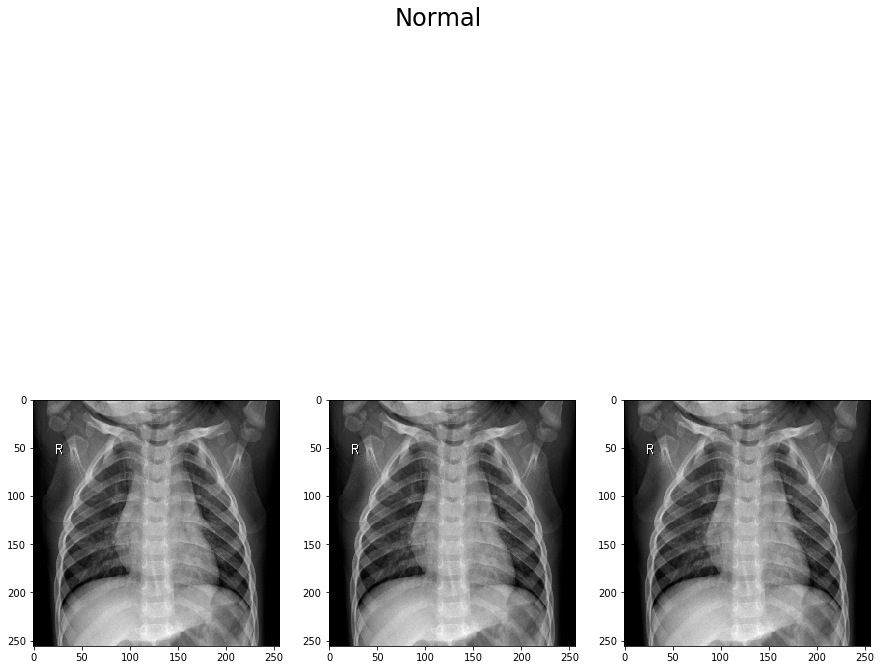

In [29]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()
    
test_path = '/content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
label = 0

# plt.imshow(load_and_preprocess_image(test_path))
# plt.grid(False)
# plt.xlabel("TEST")
# plt.title(label_names[label].title())
# print()

img = load_and_preprocess_image(test_path)
show_patient(img, label)



In [0]:
""" Building a dataset """


# ds_train = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
# train_ds = ds_train.map(load_and_preprocess_from_path_label)

# ds_val = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_labels))
# val_ds = ds_val.map(load_and_preprocess_from_path_label)

# ds_test = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
# test_ds = ds_test.map(load_and_preprocess_from_path_label)

# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# # training_batches = train_ds.cache() # filename='./resnet_train_cache.tf-data'
# # training_batches = training_batches.apply(
# #   tf.data.experimental.shuffle_and_repeat(buffer_size=500, count=count))
# train_ds = train_ds.shuffle(buffer_size=500)
# train_ds = train_ds.repeat()
# training_batches = train_ds.batch(BATCH_SIZE)

# # training_batches = training_batches.batch(BATCH_SIZE).prefetch(1)

# validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
# validation_batches = validation_batches.batch(BATCH_SIZE).prefetch(1)

# test_batches = test_ds.cache() # filename='./resnet_test_cache.tf-data'
# test_batches = test_batches.batch(BATCH_SIZE).prefetch(1)

# for i, val in enumerate(test_batches):
#   print(i, val[0].numpy().shape, val[1].numpy())


# ds_all = tf.data.Dataset.from_tensor_slices((all_imgs_pathes, all_image_labels))
# all_ds = ds_all.map(load_and_preprocess_from_path_label)

# train_ds = all_ds[:90]
# val_ds = all_ds[90:]

# train_batches = train.cache() # filename='./resnet_train_cache.tf-data'
# train_batches = train_batches.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=500, count=count))

# val_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
# val_batches = val_batches.batch(BATCH_SIZE).prefetch(1)

ds_train = tf.data.Dataset.from_tensor_slices((train_pathes, train_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

train_ds = train_ds.shuffle(buffer_size=500)
train_ds = train_ds.repeat()
training_batches = train_ds.batch(BATCH_SIZE)

ds_val = tf.data.Dataset.from_tensor_slices((val_pathes, val_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE).prefetch(1)


In [0]:
i, k = 0, 0
for img_batch, labels in validation_batches.take(16):
  print(i)
  labels = labels.numpy()
  print(labels)
  for img, label in zip(img_batch, labels):
#     show_patient(img, label)
    print('\t',k)
    k+=1
  i+=1
  k=0

0
[1 1 1 1 0 0 1 0]
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
1
[0 1 1 0 0 0 0 1]
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7


In [10]:
baseModel = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
baseModel.trainable = False
print(len(baseModel.layers))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
175


In [11]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
#feature_batch = baseModel(image_batch) # This feature extractor converts each 265x265x3 image to a 5x5x1280 block of features.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

#Add prediction head
prediction_layer = keras.layers.Dense(2) # len(label_names =1)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)





# > **Now building and compiling our model:**

1.   Stacking baseModel with the classifier head.
2.   Compiling the model.




In [0]:
model = tf.keras.Sequential([
  baseModel,
  global_average_layer,
  prediction_layer
])


base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________




# Train the last two layers of the model:
baseModel is frozen, only the added classifier head is being trained.



In [32]:
# num_train, num_val, num_test = 5216, 16, 624

validation_steps = 5

no_epochs = 10
steps_per_epoch=tf.math.ceil(len(all_imgs_pathes)/BATCH_SIZE).numpy()

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


5/5 [==============================] - 16s 3s/step - loss: 5.6414 - accuracy: 0.3500
initial loss: 5.64
initial accuracy: 0.35


In [18]:
model.fit.__doc__

'Trains the model for a fixed number of epochs (iterations on a dataset).\n\n    Arguments:\n        x: Input data. It could be:\n          - A Numpy array (or array-like), or a list of arrays\n            (in case the model has multiple inputs).\n          - A TensorFlow tensor, or a list of tensors\n            (in case the model has multiple inputs).\n          - A dict mapping input names to the corresponding array/tensors,\n            if the model has named inputs.\n          - A `tf.data` dataset or a dataset iterator. Should return a tuple\n            of either `(inputs, targets)` or\n            `(inputs, targets, sample_weights)`.\n          - A generator or `keras.utils.Sequence` returning `(inputs, targets)`\n            or `(inputs, targets, sample weights)`.\n        y: Target data. Like the input data `x`,\n          it could be either Numpy array(s) or TensorFlow tensor(s).\n          It should be consistent with `x` (you cannot have Numpy inputs and\n          tensor 

In [35]:
history = model.fit(training_batches,
                    epochs=no_epochs,
                    validation_data=validation_batches,
                    validation_steps= validation_steps,
                   steps_per_epoch=3)
# model.fit(ds, epochs=1, steps_per_epoch=3)

Epoch 1/10


W0717 18:24:41.657634 140152273397632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 9s 3s/step - loss: 5.3958 - accuracy: 0.4792 - val_loss: 5.6418 - val_accuracy: 0.3500
Epoch 2/10
3/3 [==============================] - 1s 345ms/step - loss: 8.0476 - accuracy: 0.3333 - val_loss: 5.6350 - val_accuracy: 0.3500
Epoch 3/10
3/3 [==============================] - 1s 331ms/step - loss: 5.4228 - accuracy: 0.3750 - val_loss: 5.6053 - val_accuracy: 0.3500
Epoch 4/10
3/3 [==============================] - 1s 338ms/step - loss: 5.3130 - accuracy: 0.3958 - val_loss: 5.5922 - val_accuracy: 0.3500
Epoch 5/10
3/3 [==============================] - 1s 339ms/step - loss: 4.6869 - accuracy: 0.4583 - val_loss: 5.5605 - val_accuracy: 0.3500
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 3.5430 - accuracy: 0.4583 - val_loss: 5.4539 - val_accuracy: 0.3500
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 1.7686 - accuracy: 0.5833 - val_loss: 7.6964 - val_accuracy: 0.5000
Epoch 8/10
3/3 [========================

In [36]:
model.evaluate(validation_batches, steps = validation_steps)

5/5 [==============================] - 1s 102ms/step - loss: 7.6964 - accuracy: 0.5000


[7.696424961090088, 0.5]



# Fine tune the model:



In [37]:
baseModel.trainable = True

fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.SGD(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,524,802
Non-trainable params: 67,008
_________________________________________________________________


In [39]:
fine_tune_epochs = 30
total_epochs =  no_epochs + fine_tune_epochs

history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches)


Epoch 11/40
5/5 [==============================] - 201s 40s/step - loss: 4.4829 - accuracy: 0.5750 - val_loss: 7.7002 - val_accuracy: 0.5000
Epoch 12/40
5/5 [==============================] - 8s 2s/step - loss: 2.6198 - accuracy: 0.7875 - val_loss: 7.7002 - val_accuracy: 0.5000
Epoch 13/40
5/5 [==============================] - 8s 2s/step - loss: 2.6077 - accuracy: 0.7750 - val_loss: 7.3305 - val_accuracy: 0.5000
Epoch 14/40
5/5 [==============================] - 8s 2s/step - loss: 3.0593 - accuracy: 0.7375 - val_loss: 6.1131 - val_accuracy: 0.5000
Epoch 15/40
5/5 [==============================] - 8s 2s/step - loss: 2.7199 - accuracy: 0.7125 - val_loss: 5.9536 - val_accuracy: 0.5000
Epoch 16/40
5/5 [==============================] - 8s 2s/step - loss: 1.8792 - accuracy: 0.8125 - val_loss: 5.9298 - val_accuracy: 0.5000
Epoch 17/40
5/5 [==============================] - 18s 4s/step - loss: 2.8011 - accuracy: 0.7875 - val_loss: 5.9291 - val_accuracy: 0.5000
Epoch 18/40
5/5 [=============